In [4]:
import numpy as np
import keras
from keras import layers
from keras import models
from keras import optimizers
from PIL import Image, ImageFile
import numpy as np
from matplotlib import pylab as plt
import glob
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

ImageFile.LOAD_TRUNCATED_IMAGES = True

folder = ["normal","pneumonia"]
X = []
Y = []
for index, name in enumerate(folder):
    direct = "F:/73_DNN/0_DATA BASE/20190421_chest-xray-pneumonia/" + name
    files = glob.glob(direct + "/*.jpeg")
    for i, file in enumerate(files):
        image = Image.open(file)
        image = image.convert("L")
        image = image.resize((150, 150))
        data = np.asarray(image)
        X.append(data)
        Y.append(index)
X = np.array(X)
Y = np.array(Y)
#0~1
X = X.astype('float32')
X = X / 255.0
#one hot encoarding
Y = np_utils.to_categorical(Y, 2)
#split data for train and evaluate
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

X_train_new = (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_train = np.reshape(X_train, X_train_new)
X_test_new = (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_test = np.reshape(X_test, X_test_new)

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(150,150,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.SGD(lr=0.01),
             metrics=['acc'])

history = model.fit(X_train, y_train, batch_size=32,epochs=60)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [6]:
print(model.evaluate(X_test, y_test))

634/634 [==============================] - 16s 25ms/step
[0.2379404370341015, 0.9164037856769862]


In [7]:
open('pneumonia.json',"w").write(model.to_json())
model.save_weights('pneumonia_weight.h5')

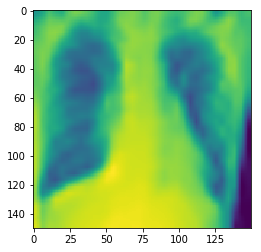

In [154]:
from keras import backend as K
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import cv2
pneumonia = img_to_array(load_img('C:/Users/龍之介/Desktop/pneumonia_visual/F.jpeg',grayscale=True, target_size=(150,150)))
pneumonia = np.expand_dims(pneumonia, axis=0)
pneumonia = pneumonia.astype('float32')
pneumonia = pneumonia / 255.0
preds = model.predict(pneumonia)
pred_argmax = np.argmax(preds[0])
pneumonia_output = model.output[:, pred_argmax]
last_conv_layer = model.get_layer('conv2d_7').output
grads = K.gradients(pneumonia_output, last_conv_layer)[0]
#pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input],[last_conv_layer, grads])
output, grads_val = iterate([pneumonia])
output, grads_val = output[0], grads_val[0]
weights = np.mean(grads_val, axis=(0,1))
cam = np.dot(output, weights)
cam = cv2.resize(cam, (150,150), cv2.INTER_LINEAR)
cam = np.maximum(cam, 0)
cam = cam / cam.max()
from PIL import Image
import numpy as np
from matplotlib import pylab as plt
plt.imshow( cam )